# Accumulated Local Effects

Just like PDPs, accumulated local effects (ALE) plots are designed to investigate the impact of varying the levels of one feature on the predicted response. The main benefit of ALE plots is that they are deemed most effective in the presence of **correlated variables**.

**Issues with PDPs**: when features in a dataset are correlated, PDPs can be misleading. Since PDPs average predictions over the marginal distribution of the features, and do not consider the correlation patterns, they can sometimes result in **unrealistic data points**. For instance, if we predict electricity prices based on temperature, time of day, and day of the week, PDPs might consider unlikely combinations, such as high electricity prices at 3 AM on weekdays. 

There are two potential solutions to this issue:
1. **Averaging over the conditional distribution**, instead of the marginal, thereby excluding the inclusion of unrealistic data points.
2. **Averaging over differences in predictions**, instead of averaging directly the predictions.

The second option is the one used by ALE plots, which compute **differences in predictions within small intervals**, ensuring the estimates are based on realistic data points. This approach makes ALE plots more reliable when features are correlated.

## Estimation
In practice, the ALE for the $j$th feature, $x_j$, is estimated by:

\begin{equation}
    \hat{f}_{j,\text{ALE}}(x) = \sum_{k=1}^{k(x)} \frac{1}{n_j(k)} \sum_{i : x_j^{(i)} \in N_j(k)} \left( \hat{f}(z_{k,j}, x_{-j}^{(i)}) - \hat{f}(z_{k-1,j}, x_{-j}^{(i)}) \right)
\end{equation}

where $N_j(k)$ is the $k$th interval for feature $x_j$, $z_{k,j}$ is the upper boundary of the $k$th interval, $x_{-j}^{(i)}$ are all the other features except $x_j$, for the $i$th data point, and $n_j(k)$ is the number of data points in the $k$th interval.

The previous equation represents the following steps:
1. **Divide the feature into intervals**: split the range of the variable of interest $h$ into $m$ intervals, often based on quantiles to ensure an equal number of data points in each interval.
2. **Compute local effects**: for each interval, compute the difference in model predictions when $h$ is replaced by the interval's lower and upper bounds.
3. **Accumulate local effects**: sum up the local effects within each interval to obtain the accumulated effect.
4. **Center the ALE plot**: subtract the mean accumulated effect to center the plot around zero.

Thus, we are simply calculating the average difference in predictions when the feature of interest is changed from the lower to the upper boundary of the interval, and accumulating these differences across all intervals.

This process is expected to perform better than PDP for correlated features because it accounts for the dependencies between features, ensuring that the differences in predictions are computed based on realistic data points. By focusing on local changes within intervals, ALE plots provide a more accurate representation of feature effects in the presence of correlations.

Here is a simple manual implementation of ALE:

In [1]:
import numpy as np

def calculate_ale(feature_name, feature_values, X, model, num_intervals=10):
    interval_edges = np.linspace(min(feature_values), max(feature_values), num_intervals + 1)
    ale_values = np.zeros(num_intervals)
    X_temp = X.copy()
    
    for i in range(num_intervals):
        lower = interval_edges[i]
        upper = interval_edges[i + 1]
        
        in_interval = (X[feature_name] >= lower) & (X[feature_name] < upper)
        if in_interval.sum() == 0:
            continue
        
        X_temp[feature_name] = lower
        preds_lower = model.predict(X_temp)
        
        X_temp[feature_name] = upper
        preds_upper = model.predict(X_temp)
        
        ale_values[i] = np.mean(preds_upper[in_interval] - preds_lower[in_interval])
    
    ale_accumulated = np.cumsum(ale_values)
    ale_accumulated -= np.mean(ale_accumulated)
    
    return interval_edges[:-1], ale_accumulated

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


The provided function `calculate_ale computes` the ALE values for a specified feature using a given machine learning model. While PDPs show the average effect of a feature on the predicted outcome by setting the feature to specific values across the entire dataset and averaging the model's predictions, ALE plots focus on the localised impact of a feature by examining changes in predictions within small intervals of the feature's range. This means that ALE accounts for interactions between features by focusing on local changes, making it less sensitive to the assumption of feature independence that PDP relies on. Consequently, ALE provides a more nuanced view of how small changes in the feature's value influence the model's predictions, reflecting local dependencies and interactions, whereas PDP offers a global, averaged view that may obscure these local variations and interactions. Thus, ALE is particularly useful in datasets with correlated features where the assumption of feature independence in PDP may lead to misleading interpretations.

Let's now generate some data to show how they work in practice. For simplicity, we will use the same example sued to show PDPs.

In [2]:
import pandas as pd

# Simulate data
np.random.seed(0)
n_samples = 1000
temperature = np.random.uniform(0, 40, n_samples)  # Temperature in Celsius
time_of_day = np.random.uniform(0, 24, n_samples)  # Time of day in hours
day_of_week = np.random.randint(0, 7, n_samples)  # Day of the week (0=Sunday, 6=Saturday)

# Simulate electricity price with desired patterns
price = (0.2 * (temperature - 20)**2 +  # Quadratic effect of temperature
         5 * np.sin((time_of_day - 7) * np.pi / 6) * (time_of_day >= 7) * (time_of_day <= 10) +  # Peak between 7 AM and 10 AM
         5 * np.sin((time_of_day - 18) * np.pi / 4) * (time_of_day >= 18) * (time_of_day <= 22) +  # Peak between 6 PM and 10 PM
         -5 * np.sin((time_of_day - 10) * np.pi / 7) * (time_of_day >= 10) * (time_of_day <= 17) +  # Trough between 10 AM and 5 PM
         7 * np.sin((time_of_day) * np.pi / 24) +  # Sinusoidal effect throughout the day
         2 * (1 - np.cos(day_of_week * np.pi / 7)) +  # Higher prices on Sunday with smooth transition
         np.random.normal(0, 2, n_samples))  # Noise

# Convert to DataFrame for convenience
data = pd.DataFrame({
    'Temperature': temperature,
    'Hour': time_of_day,
    'Day': day_of_week,
    'Price': price
})

# Display the first few rows
data.head()

,Temperature,Hour,Day,Price
0,21.952540,14.229126,3,1.830310
1,28.607575,0.241529,3,16.398082
2,24.110535,11.419829,3,8.902574
3,21.795327,17.010489,5,9.614504
4,16.946192,1.055410,4,3.108261


We can now fit a regression model (e.g., random forest), and compute the ALE:

In [3]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Split data into features and target
X = data[['Temperature', 'Hour', 'Day']]
y = data['Price']

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=10, random_state=0)
model.fit(X, y)

# Calculate ALE for "Hour" feature
hour_values = np.linspace(0, 24, 48)
intervals_hour, ale_hour = calculate_ale('Hour', hour_values, X, model)

We now used intervals of 30 minutes, which are typically referred to as **settlement periods (SPs)** in the electricity markets.

Let's plot the resulting ALE plot:

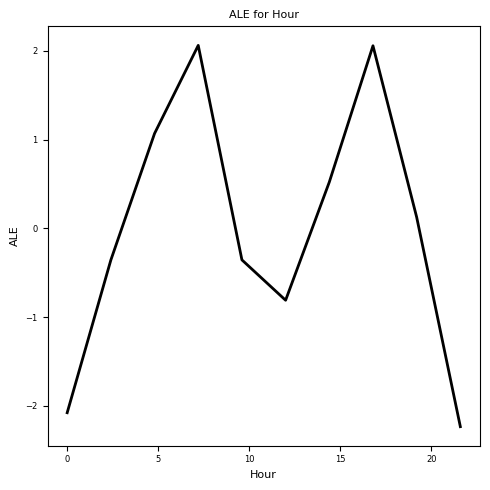

In [4]:
# Plot the ALE for "Hour" feature
plt.figure(figsize=(5, 5))
plt.plot(intervals_hour, ale_hour, color='k', linewidth=2)
plt.title('ALE for Hour', fontsize=8)
plt.xlabel('Hour', fontsize=8)
plt.ylabel('ALE', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

## Bootstrapping

As we did for the PDPs, we can run the procedure multiple times for each feature to construct **Bootstrap confidence intervals** for the estimated ALE plots.

In [5]:
# Define the range of values for each feature
temperature_values = np.linspace(0, 35, 70)
hour_values = np.linspace(0, 24, 48)
day_values = np.arange(7)

# Calculate ALEs with bootstrapping
n_bootstraps = 100
ale_temperature_bootstraps = []
ale_hour_bootstraps = []
ale_day_bootstraps = []

for _ in range(n_bootstraps):
    # Bootstrap sample
    indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    X_bootstrap = X.iloc[indices]
    y_bootstrap = y.iloc[indices]
    
    # Train model on bootstrap sample
    model_bootstrap = RandomForestRegressor(n_estimators=10, random_state=0)
    model_bootstrap.fit(X_bootstrap, y_bootstrap)
    
    # Calculate ALEs for each feature
    intervals_temperature, ale_temperature = calculate_ale('Temperature', temperature_values, X, model_bootstrap)
    intervals_hour, ale_hour = calculate_ale('Hour', hour_values, X, model_bootstrap)
    intervals_day, ale_day = calculate_ale('Day', day_values, X, model_bootstrap)
    
    ale_temperature_bootstraps.append(ale_temperature)
    ale_hour_bootstraps.append(ale_hour)
    ale_day_bootstraps.append(ale_day)

# Convert results to numpy arrays for easier manipulation
ale_temperature_bootstraps = np.array(ale_temperature_bootstraps)
ale_hour_bootstraps = np.array(ale_hour_bootstraps)
ale_day_bootstraps = np.array(ale_day_bootstraps)

# Compute mean and confidence intervals
mean_ale_temperature = np.mean(ale_temperature_bootstraps, axis=0)
mean_ale_hour = np.mean(ale_hour_bootstraps, axis=0)
mean_ale_day = np.mean(ale_day_bootstraps, axis=0)
ci_temperature = np.percentile(ale_temperature_bootstraps, [2.5, 97.5], axis=0)
ci_hour = np.percentile(ale_hour_bootstraps, [2.5, 97.5], axis=0)
ci_day = np.percentile(ale_day_bootstraps, [2.5, 97.5], axis=0)

## ALE Plots

Let's plot the results

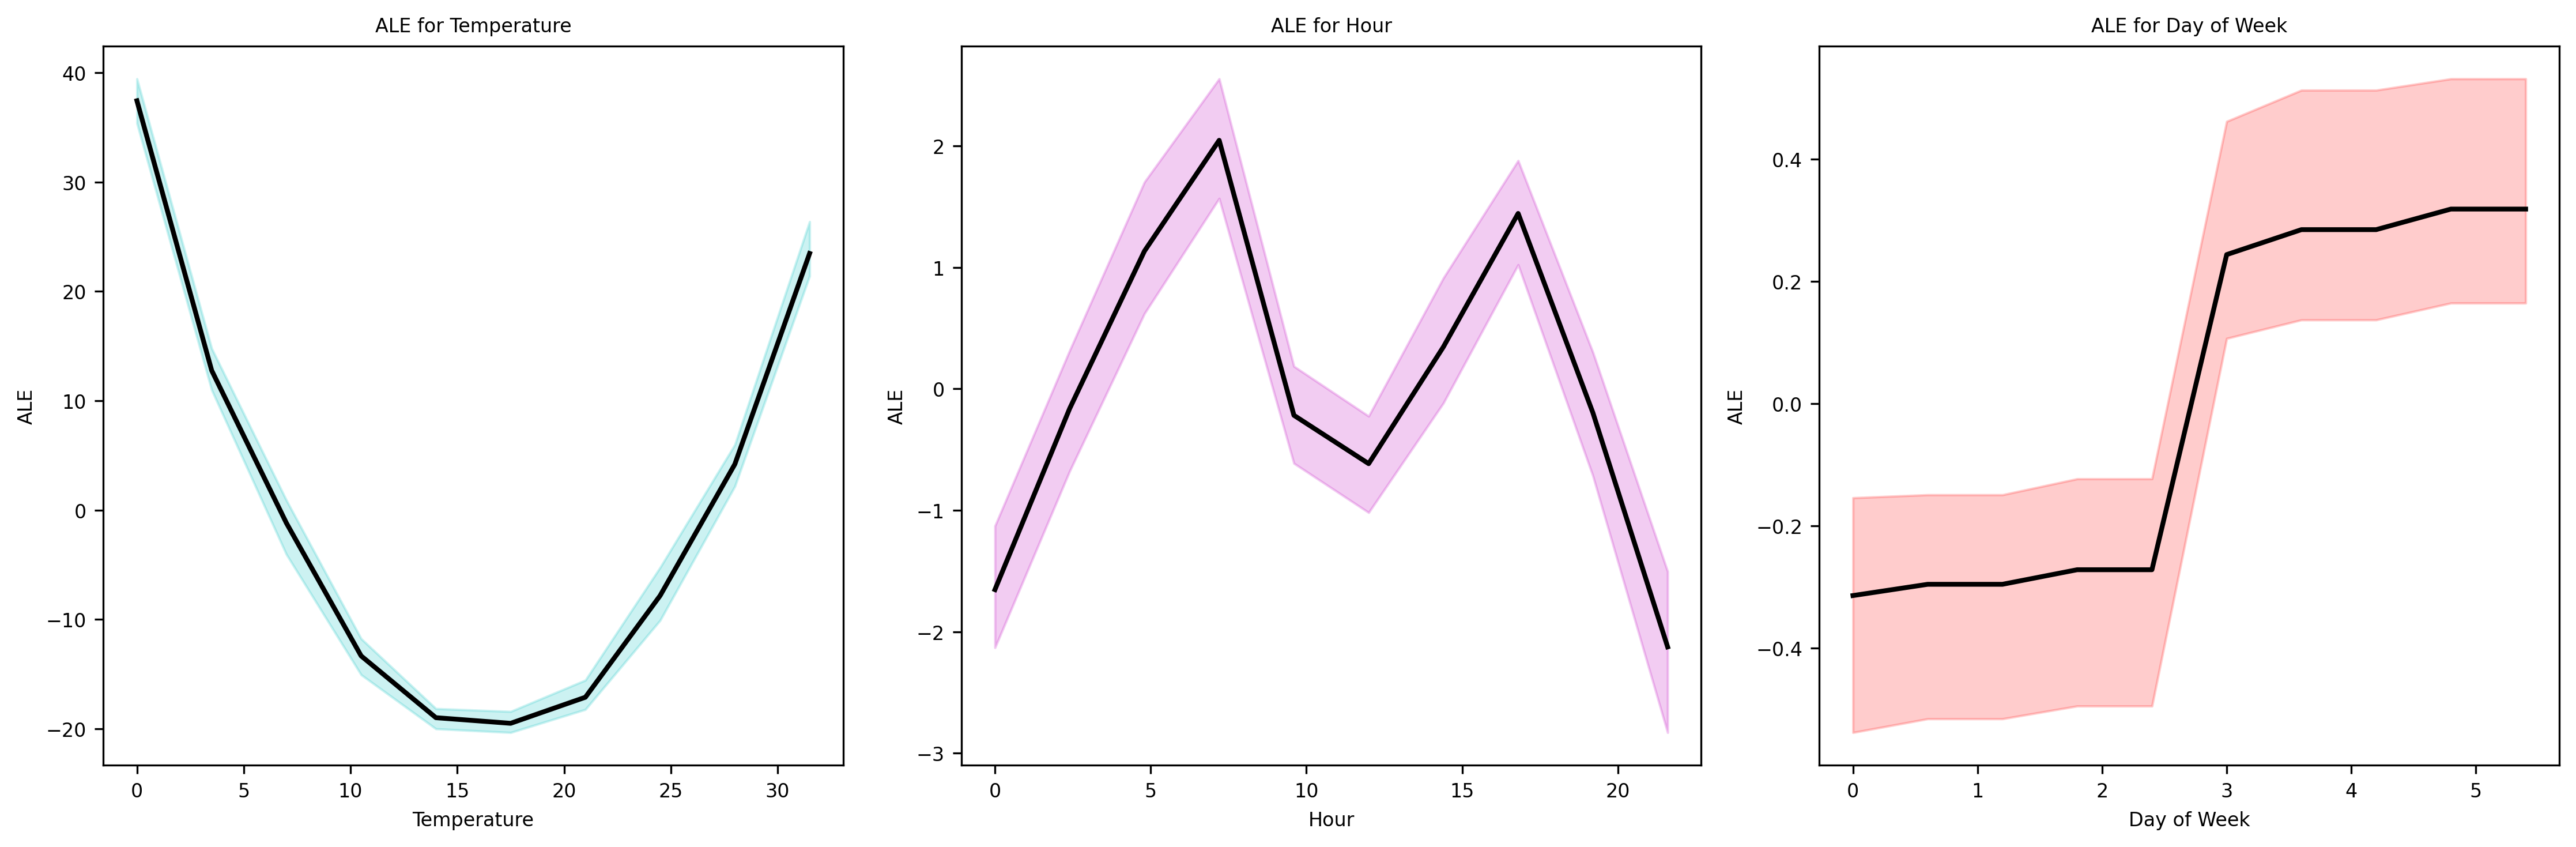

In [6]:
# Plot ALEs with confidence intervals
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

fontsize = 8  # Set the font size for all labels

# Temperature
ax[0].plot(intervals_temperature, mean_ale_temperature, label='ALE', color='k', linewidth=2)
ax[0].fill_between(intervals_temperature, ci_temperature[0], ci_temperature[1], color='c', alpha=0.2)
ax[0].set_title('ALE for Temperature', fontsize=fontsize)
ax[0].set_xlabel('Temperature', fontsize=fontsize)
ax[0].set_ylabel('ALE', fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)

# Hour
ax[1].plot(intervals_hour, mean_ale_hour, label='ALE', color='k', linewidth=2)
ax[1].fill_between(intervals_hour, ci_hour[0], ci_hour[1], color='m', alpha=0.2)
ax[1].set_title('ALE for Hour', fontsize=fontsize)
ax[1].set_xlabel('Hour', fontsize=fontsize)
ax[1].set_ylabel('ALE', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)

# Day
ax[2].plot(intervals_day, mean_ale_day, label='ALE', color='k', linewidth=2)
ax[2].fill_between(intervals_day, ci_day[0], ci_day[1], color='r', alpha=0.2)
ax[2].set_title('ALE for Day of Week', fontsize=fontsize)
ax[2].set_xlabel('Day of Week', fontsize=fontsize)
ax[2].set_ylabel('ALE', fontsize=fontsize)
ax[2].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()

As we can see, the effects of Hour and Temperature variables have been properly identified. To try and see the potential benefits ovet PDPs, we could generated correlated data and see if ALE plots offer improvements,